In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D

from keras.preprocessing import image

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

from keras.applications import ResNet50
# from keras.applications import Xception # TensorFlow ONLY

from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
import argparse
import cv2

from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Using Resnet50 and initialised with weights of imagenet
## images in smear 2005 are resized to 224 x224 

In [2]:
img_height,img_width = 224,224
num_classes = 7
input_shape= (img_height,img_width,3)
base_model=ResNet50(weights='imagenet',include_top=False,input_shape= (img_height,img_width,3)) #imports the mobilenet model and discards the last 1000 neuron layer.

/home/thamizharasi/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## Added three dense layers and the last layer is having 7 classes

In [12]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(num_classes,activation='softmax')(x) #final layer with softmax activation


## created new model using base model input and output with 7 classes

In [13]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

## Displayed model details

In [14]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

## Created function to computer F1 SCORE

In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Compiled model using Adam optimizer and computed accuracy and f1 score

In [16]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',f1])

## Applied image data generator with rotation till 90, equalization, flipping, width shift and height shift 

In [17]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from imutils import paths
import os
from keras_preprocessing import image
from shutil import copyfile


train_datagen = ImageDataGenerator(
       
        contrast_stretching=True, 
        adaptive_equalization=True, 
        histogram_equalization=True,
        rotation_range=90,
        brightness_range=[0.5,2.5],
        width_shift_range=0.1,
        height_shift_range=0.1,
        
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')






val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode= 'categorical')

validation_generator = val_datagen.flow_from_directory(
        'dataset/validation',
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


results=model.fit_generator(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=callbacks_list, 
        verbose=1,
        validation_steps=20)

Found 847 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
Epoch 1/20
27/27 [==============================] - 325s 12s/step - loss: 1.9039 - accuracy: 0.2715 - f1: 0.0823 - val_loss: 69.3302 - val_accuracy: 0.1800 - val_f1: 0.1800

Epoch 00001: val_accuracy improved from -inf to 0.18000, saving model to weights-improvement-01-0.18.hdf5
Epoch 2/20
27/27 [==============================] - 302s 11s/step - loss: 1.5978 - accuracy: 0.3365 - f1: 0.0979 - val_loss: 348.7116 - val_accuracy: 0.1500 - val_f1: 0.1505

Epoch 00002: val_accuracy did not improve from 0.18000
Epoch 3/20
27/27 [==============================] - 303s 11s/step - loss: 1.4678 - accuracy: 0.3908 - f1: 0.2042 - val_loss: 7.5252 - val_accuracy: 0.1750 - val_f1: 0.1482

Epoch 00003: val_accuracy did not improve from 0.18000
Epoch 4/20
27/27 [==============================] - 312s 12s/step - loss: 1.4284 - accuracy: 0.4144 - f1: 0.2337 - val_loss: 50.8809 - val_accuracy: 0.1550 - val_f1: 0.1550

Epoch 0

## Displaying plot of Accuracy Vs epochs

Text(0, 0.5, 'Accuracy')

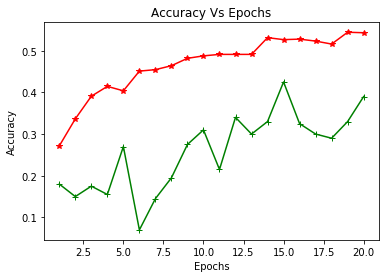

In [18]:
import matplotlib
from matplotlib import pyplot as plt
results1=results.history
training_accuracy=results1['accuracy']
val_acc=results1['val_accuracy']
epochs1=range(1,len(training_accuracy)+1)
plt.plot(epochs1,training_accuracy,label='Training Accuracy',marker="*",color='r')
plt.plot(epochs1,val_acc,label='Validation Accuracy',marker="+",color='g')
plt.title('Accuracy Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

## Displaying plot of Loss Vs epochs

Text(0, 0.5, 'Loss')

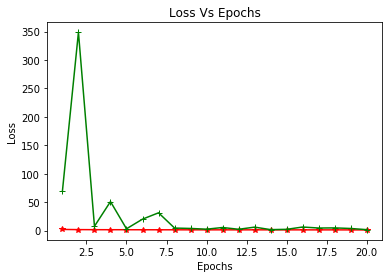

In [19]:
trainloss=results1['loss']
valloss=results1['val_loss']
epochs1=range(1,len(trainloss)+1)
plt.plot(epochs1,trainloss,label='Training Loss',marker="*",color='r')
plt.plot(epochs1,valloss,label='Validation Loss',marker="+",color='g')
plt.title('Loss Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

## Displaying plot of F1 score Vs epochs

Text(0, 0.5, 'F1 score')

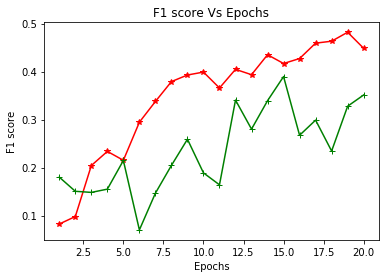

In [20]:
trainf1=results1['f1']
valf1=results1['val_f1']
epochs1=range(1,len(trainf1)+1)
plt.plot(epochs1,trainf1,label='Training F1 score',marker="*",color='r')
plt.plot(epochs1,valf1,label='Validation F1 score',marker="+",color='g')
plt.title('F1 score Vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 score')